In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
sys.path.append('/content/drive/My Drive/ENM_5320_Final_Project')
path = "/content/drive/My Drive/ENM_5320_Final_Project"
os.chdir(path)

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
from pathlib import Path
from IPython.display import clear_output
import ipywidgets as widgets
from time import sleep
from tqdm import trange
import wandb

from FNO import FNO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


In [3]:
# global parameters
B = 15 # batch size
nx = 500 # npts
n_sols = 5000

modes = 24
num_fourier_layers = 4
in_channels = 4
out_channels = 3
fourier_channels = 64
activation = nn.Tanh()
epochs = 10000

checkpt_path = path+'/checkpoints/'
data_path=path+'/data/'

In [30]:
with open(data_path+f"{n_sols}_inputs_train.pkl", 'rb') as file:
    inputs_test = pkl.load(file)
len(inputs_test)
inputs_test[0][:][3]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

# Initialize Data Loader

In [34]:
class SodShockData(Dataset):
    def __init__(self, path, n_sols, split: str = "train"):
        super(SodShockData, self).__init__()
        with open(Path(path) / f"{n_sols}_inputs_{split}.pkl", 'rb') as file:
            self.input_data = np.array(pkl.load(file))

        with open(Path(path) / f"{n_sols}_outputs_{split}.pkl", 'rb') as file:
            self.output_data = np.array(pkl.load(file))

        self.train_input_means=[]
        self.train_input_stds=[]
        self.train_output_means=[]
        self.train_output_stds=[]
    def __len__(self):
        return len(self.input_data)

    def normalize_training_data(self):

      for i in range(len(self.input_data[0])):
        mean = self.input_data[:][i].mean()
        std = self.input_data[:][i].std()
        # ensure numerical stability
        if std <= 1e-10:
          std += 1e-6
        self.input_data[:,i] = (self.input_data[:,i]-mean)/std
        self.train_input_means.append(mean)
        self.train_input_stds.append(std)

      for i in range(len(self.output_data[0])):
        mean = self.output_data[:][i].mean()
        std = self.output_data[:][i].std()

        # ensure numerical stability
        if std <= 1e-10:
          std += 1e-6
        self.output_data[:][i] = (self.output_data[:][i]-mean)/std
        self.train_output_means.append(mean)
        self.train_output_stds.append(std)

    def normalize_test_data(self, train_input_means, train_input_stds, train_output_means, train_output_stds):
      for i in range(len(self.input_data[0])):
        mean = train_input_means[i]
        std = train_input_stds[i]
        self.input_data[:][i] = (self.input_data[:][i]-mean)/std

      for i in range(len(self.output_data[0])):
        mean = train_output_means[i]
        std = train_output_stds[i]
        self.output_data[:][i] = (self.output_data[:][i]-mean)/std

    def unnormalize_training_data(self):
      for i in range(len(self.input_data[0])):
        mean = self.train_input_means[i]
        std = self.train_input_stds[i]
        self.input_data[:][i] = self.input_data[:][i]*std + mean

      for i in range(len(self.output_data[0])):
        mean = self.train_output_means[i]
        std = self.train_output_stds[i]
        self.output_data[:][i] = self.output_data[:][i]*std + mean

    def unnormalize_test_data(self, train_input_means, train_input_stds, train_output_means, train_output_stds):
      for i in range(len(self.input_data[0])):
        mean = train_input_means[i]
        std = train_input_stds[i]
        self.input_data[:][i] = self.input_data[:][i]*std + mean

      for i in range(len(self.output_data[0])):
        mean = train_output_means[i]
        std = train_output_stds[i]
        self.output_data[:][i] = self.output_data[:][i]*std + mean


    def __getitem__(self, idx:int):
        inp = self.input_data[idx]
        x, p, rho, u = inp
        input_data = torch.stack((torch.as_tensor(x),torch.as_tensor(p),
                                  torch.as_tensor(rho),torch.as_tensor(u)), dim=-1)

        out = self.output_data[idx]
        p, rho, u = out
        output_data = torch.stack((torch.as_tensor(p),torch.as_tensor(rho),
                                   torch.as_tensor(u)), dim=-1)
        return (input_data.float().to(device), output_data.float().to(device))

In [36]:
train_dataset = SodShockData(
    path=data_path,
    n_sols=n_sols,
    split="train",
)

#train_dataset.normalize_training_data()

train_loader = DataLoader(
    train_dataset,
    batch_size=B,
    shuffle=True,
)
len(train_dataset)


test_dataset = SodShockData(
    path=data_path,
    n_sols=n_sols,
    split="test",
)

#test_dataset.normalize_test_data(train_dataset.train_input_means, train_dataset.train_input_stds, train_dataset.train_output_means, train_dataset.train_output_stds)

test_loader = DataLoader(
    test_dataset,
    batch_size=B,
    shuffle=True,
)
len(test_dataset)

125

In [37]:
input_data, output_data = train_dataset[0]
input_data.shape
#print(input_data.shape)
#print(output_data.shape)
torch.as_tensor(train_dataset.input_data).shape
input_data[:,1]
output_data[:,0]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

In [98]:
for batch in train_loader:
    inputs, outputs = batch
    # print(outputs)
    break

In [8]:
"""def model_train(model, train_loader, optimizer, loss_fn, epochs):

    wandb.init(project="ENM_5320_Project", name="fno-training", reinit="create_new")

    # Log model configuration to wandb
    wandb.config.update({
        "learning_rate": optimizer.param_groups[0]['lr'],
        "epochs": epochs,
        "batch_size": train_loader.batch_size,
        "loss_function": type(loss_fn).__name__,
        # Add other relevant model parameters here
    })

    # Watch model for gradients and parameters logging
    wandb.watch(model, log="all", log_freq=100)

    # Training loop
    for epoch in trange(epochs):
        for batch in train_loader:
            inputs, outputs = batch
            pred = model(inputs)

            loss = loss_fn(pred, outputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 20 == 0 or epoch == epochs:
            wandb.log({"train_loss": loss})
            if epoch % 100 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss}')

    # Finish wandb run
    wandb.finish()
    save_checkpoint(model, optimizer, epoch, "fno")
    return model.state_dict(), optimizer.state_dict()"""

'def model_train(model, train_loader, optimizer, loss_fn, epochs):\n\n    wandb.init(project="ENM_5320_Project", name="fno-training", reinit="create_new")\n\n    # Log model configuration to wandb\n    wandb.config.update({\n        "learning_rate": optimizer.param_groups[0][\'lr\'],\n        "epochs": epochs,\n        "batch_size": train_loader.batch_size,\n        "loss_function": type(loss_fn).__name__,\n        # Add other relevant model parameters here\n    })\n\n    # Watch model for gradients and parameters logging\n    wandb.watch(model, log="all", log_freq=100)\n\n    # Training loop\n    for epoch in trange(epochs):\n        for batch in train_loader:\n            inputs, outputs = batch\n            pred = model(inputs)\n\n            loss = loss_fn(pred, outputs)\n\n            optimizer.zero_grad()\n            loss.backward()\n            optimizer.step()\n\n        if epoch % 20 == 0 or epoch == epochs:\n            wandb.log({"train_loss": loss})\n            if epoch %

# Train and Save Model

In [38]:
# model initialization
model = FNO(modes=modes, num_fourier_layers=num_fourier_layers, in_channels=in_channels, hidden_channels=num_fourier_layers, out_channels=out_channels, activation=activation).to(device)

# initialize optimizer
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
l = nn.MSELoss()
#model_state, optimizer_state = model_train(model, train_loader, optimizer, l, epochs)
train_loss_log = []
test_loss_log=[]

for epoch in trange(epochs):
    train_losses = []
    for batch in train_loader:
        inputs, outputs = batch
        pred = model(inputs)


        train_loss = l(pred, outputs)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.detach().cpu().item())
        # print(loss)
        #zero_grad
        #backwards
        #step
        # print(inputs.shape, outputs.shape)
    if epoch % 10 == 0 or epoch == epochs:
        train_loss_log.append(np.mean(train_losses))
        test_losses=[]
        with torch.no_grad():
          for batch in test_loader:
            inputs, outputs = batch
            pred = model(inputs)
            test_loss = l(pred, outputs)
            test_losses.append(test_loss.detach().cpu().item())
        test_loss_log.append(np.mean(test_losses))
        if epoch % 100 == 0 or epoch == epochs:
          print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss}')
          print(f'Epoch [{epoch+1}/{epochs}], Validation Loss: {test_loss}')


  0%|          | 1/10000 [00:01<4:47:29,  1.73s/it]

Epoch [1/10000], Training Loss: 1.3168913125991821
Epoch [1/10000], Validation Loss: 2.6455373764038086


  1%|          | 101/10000 [00:27<40:23,  4.08it/s]

Epoch [101/10000], Training Loss: 0.003961660899221897
Epoch [101/10000], Validation Loss: 0.08303119987249374


  2%|▏         | 201/10000 [00:51<51:04,  3.20it/s]

Epoch [201/10000], Training Loss: 0.0021098055876791477
Epoch [201/10000], Validation Loss: 0.03230041265487671


  3%|▎         | 301/10000 [01:15<38:20,  4.22it/s]

Epoch [301/10000], Training Loss: 0.0011056155199185014
Epoch [301/10000], Validation Loss: 0.03451855480670929


  4%|▍         | 401/10000 [01:40<37:37,  4.25it/s]

Epoch [401/10000], Training Loss: 0.0007058788905851543
Epoch [401/10000], Validation Loss: 0.04166422411799431


  5%|▌         | 501/10000 [02:05<37:31,  4.22it/s]

Epoch [501/10000], Training Loss: 0.0005773723823949695
Epoch [501/10000], Validation Loss: 0.015396215952932835


  6%|▌         | 601/10000 [02:29<37:02,  4.23it/s]

Epoch [601/10000], Training Loss: 0.0004987870343029499
Epoch [601/10000], Validation Loss: 0.03593837469816208


  7%|▋         | 701/10000 [02:54<37:09,  4.17it/s]

Epoch [701/10000], Training Loss: 0.0004598695959430188
Epoch [701/10000], Validation Loss: 0.05980107560753822


  8%|▊         | 801/10000 [03:19<39:18,  3.90it/s]

Epoch [801/10000], Training Loss: 0.00041419535409659147
Epoch [801/10000], Validation Loss: 0.03771032765507698


  9%|▉         | 901/10000 [03:44<46:12,  3.28it/s]

Epoch [901/10000], Training Loss: 0.0003444697067607194
Epoch [901/10000], Validation Loss: 0.017483292147517204


 10%|█         | 1001/10000 [04:07<35:00,  4.28it/s]

Epoch [1001/10000], Training Loss: 0.00035545098944567144
Epoch [1001/10000], Validation Loss: 0.03538736328482628


 11%|█         | 1101/10000 [04:32<34:42,  4.27it/s]

Epoch [1101/10000], Training Loss: 0.0002274269936606288
Epoch [1101/10000], Validation Loss: 0.035938166081905365


 12%|█▏        | 1201/10000 [04:57<34:27,  4.26it/s]

Epoch [1201/10000], Training Loss: 0.0002689461980480701
Epoch [1201/10000], Validation Loss: 0.016557207331061363


 13%|█▎        | 1301/10000 [05:22<34:32,  4.20it/s]

Epoch [1301/10000], Training Loss: 0.00022428027295973152
Epoch [1301/10000], Validation Loss: 0.04570891335606575


 14%|█▍        | 1401/10000 [05:46<34:53,  4.11it/s]

Epoch [1401/10000], Training Loss: 0.0002083184226648882
Epoch [1401/10000], Validation Loss: 0.021598633378744125


 15%|█▌        | 1501/10000 [06:10<45:12,  3.13it/s]

Epoch [1501/10000], Training Loss: 0.0003335028304718435
Epoch [1501/10000], Validation Loss: 0.02909800224006176


 16%|█▌        | 1601/10000 [06:34<36:49,  3.80it/s]

Epoch [1601/10000], Training Loss: 0.0003681983216665685
Epoch [1601/10000], Validation Loss: 0.007541043218225241


 17%|█▋        | 1701/10000 [06:59<33:15,  4.16it/s]

Epoch [1701/10000], Training Loss: 0.0002368880232097581
Epoch [1701/10000], Validation Loss: 0.02813572995364666


 18%|█▊        | 1801/10000 [07:24<32:00,  4.27it/s]

Epoch [1801/10000], Training Loss: 0.0002632673131301999
Epoch [1801/10000], Validation Loss: 0.028714634478092194


 19%|█▉        | 1901/10000 [07:48<32:02,  4.21it/s]

Epoch [1901/10000], Training Loss: 0.0002761651703622192
Epoch [1901/10000], Validation Loss: 0.01686297170817852


 20%|██        | 2001/10000 [08:14<30:25,  4.38it/s]

Epoch [2001/10000], Training Loss: 0.0001902309595607221
Epoch [2001/10000], Validation Loss: 0.006874467711895704


 21%|██        | 2101/10000 [08:38<32:05,  4.10it/s]

Epoch [2101/10000], Training Loss: 0.0001941685623023659
Epoch [2101/10000], Validation Loss: 0.03423600271344185


 22%|██▏       | 2201/10000 [09:02<40:00,  3.25it/s]

Epoch [2201/10000], Training Loss: 0.00015432530199177563
Epoch [2201/10000], Validation Loss: 0.04187407344579697


 23%|██▎       | 2301/10000 [09:26<29:48,  4.31it/s]

Epoch [2301/10000], Training Loss: 0.00030987447826191783
Epoch [2301/10000], Validation Loss: 0.042038992047309875


 24%|██▍       | 2401/10000 [09:50<29:54,  4.23it/s]

Epoch [2401/10000], Training Loss: 0.0001473118318244815
Epoch [2401/10000], Validation Loss: 0.011694945394992828


 25%|██▌       | 2501/10000 [10:15<29:21,  4.26it/s]

Epoch [2501/10000], Training Loss: 0.0002347591071156785
Epoch [2501/10000], Validation Loss: 0.05052315443754196


 26%|██▌       | 2601/10000 [10:39<29:08,  4.23it/s]

Epoch [2601/10000], Training Loss: 0.00012303941184654832
Epoch [2601/10000], Validation Loss: 0.017077095806598663


 27%|██▋       | 2701/10000 [11:04<29:28,  4.13it/s]

Epoch [2701/10000], Training Loss: 0.00016978052735794336
Epoch [2701/10000], Validation Loss: 0.020449865609407425


 28%|██▊       | 2801/10000 [11:29<35:57,  3.34it/s]

Epoch [2801/10000], Training Loss: 0.00012816736125387251
Epoch [2801/10000], Validation Loss: 0.045611996203660965


 29%|██▉       | 2901/10000 [11:52<33:37,  3.52it/s]

Epoch [2901/10000], Training Loss: 0.00020035385387018323
Epoch [2901/10000], Validation Loss: 0.02686617523431778


 30%|███       | 3001/10000 [12:16<27:00,  4.32it/s]

Epoch [3001/10000], Training Loss: 0.00010968160495394841
Epoch [3001/10000], Validation Loss: 0.011720214039087296


 31%|███       | 3101/10000 [12:41<26:51,  4.28it/s]

Epoch [3101/10000], Training Loss: 0.0001261068828171119
Epoch [3101/10000], Validation Loss: 0.00669454038143158


 32%|███▏      | 3201/10000 [13:05<26:59,  4.20it/s]

Epoch [3201/10000], Training Loss: 0.00010557544737821445
Epoch [3201/10000], Validation Loss: 0.017055179923772812


 33%|███▎      | 3301/10000 [13:30<26:50,  4.16it/s]

Epoch [3301/10000], Training Loss: 9.027360647451133e-05
Epoch [3301/10000], Validation Loss: 0.025738192722201347


 34%|███▍      | 3401/10000 [13:54<32:10,  3.42it/s]

Epoch [3401/10000], Training Loss: 0.0002974827657453716
Epoch [3401/10000], Validation Loss: 0.009671510197222233


 35%|███▌      | 3501/10000 [14:18<32:20,  3.35it/s]

Epoch [3501/10000], Training Loss: 0.00017232593381777406
Epoch [3501/10000], Validation Loss: 0.023237252607941628


 36%|███▌      | 3601/10000 [14:43<24:56,  4.28it/s]

Epoch [3601/10000], Training Loss: 9.237619087798521e-05
Epoch [3601/10000], Validation Loss: 0.02681807056069374


 37%|███▋      | 3701/10000 [15:07<24:24,  4.30it/s]

Epoch [3701/10000], Training Loss: 0.00010809867671923712
Epoch [3701/10000], Validation Loss: 0.022562863305211067


 38%|███▊      | 3801/10000 [15:32<24:32,  4.21it/s]

Epoch [3801/10000], Training Loss: 0.0002897582307923585
Epoch [3801/10000], Validation Loss: 0.018219945952296257


 39%|███▉      | 3901/10000 [15:56<23:54,  4.25it/s]

Epoch [3901/10000], Training Loss: 0.00010118645877810195
Epoch [3901/10000], Validation Loss: 0.027720298618078232


 40%|████      | 4001/10000 [16:21<24:48,  4.03it/s]

Epoch [4001/10000], Training Loss: 9.650894207879901e-05
Epoch [4001/10000], Validation Loss: 0.010304237715899944


 41%|████      | 4101/10000 [16:45<29:40,  3.31it/s]

Epoch [4101/10000], Training Loss: 0.00011642811296042055
Epoch [4101/10000], Validation Loss: 0.024178333580493927


 42%|████▏     | 4201/10000 [17:09<22:11,  4.36it/s]

Epoch [4201/10000], Training Loss: 0.00019679767137859017
Epoch [4201/10000], Validation Loss: 0.012903259135782719


 43%|████▎     | 4301/10000 [17:33<22:18,  4.26it/s]

Epoch [4301/10000], Training Loss: 9.007939661387354e-05
Epoch [4301/10000], Validation Loss: 0.01926783099770546


 44%|████▍     | 4401/10000 [17:58<25:30,  3.66it/s]

Epoch [4401/10000], Training Loss: 0.00013364457117859274
Epoch [4401/10000], Validation Loss: 0.003943378571420908


 45%|████▌     | 4501/10000 [18:23<22:01,  4.16it/s]

Epoch [4501/10000], Training Loss: 0.00024135102285072207
Epoch [4501/10000], Validation Loss: 0.011548783630132675


 46%|████▌     | 4601/10000 [18:47<21:53,  4.11it/s]

Epoch [4601/10000], Training Loss: 0.00022448558593168855
Epoch [4601/10000], Validation Loss: 0.0220283605158329


 47%|████▋     | 4701/10000 [19:12<27:37,  3.20it/s]

Epoch [4701/10000], Training Loss: 9.996806329581887e-05
Epoch [4701/10000], Validation Loss: 0.008260110393166542


 48%|████▊     | 4801/10000 [19:36<24:04,  3.60it/s]

Epoch [4801/10000], Training Loss: 0.00022018856543581933
Epoch [4801/10000], Validation Loss: 0.02008085884153843


 49%|████▉     | 4901/10000 [20:00<19:59,  4.25it/s]

Epoch [4901/10000], Training Loss: 0.00015714927576482296
Epoch [4901/10000], Validation Loss: 0.012184332124888897


 50%|█████     | 5001/10000 [20:24<19:07,  4.36it/s]

Epoch [5001/10000], Training Loss: 6.216726615093648e-05
Epoch [5001/10000], Validation Loss: 0.01620401442050934


 51%|█████     | 5101/10000 [20:48<19:07,  4.27it/s]

Epoch [5101/10000], Training Loss: 6.091881368774921e-05
Epoch [5101/10000], Validation Loss: 0.007139584049582481


 52%|█████▏    | 5201/10000 [21:13<24:08,  3.31it/s]

Epoch [5201/10000], Training Loss: 0.00021596603619400412
Epoch [5201/10000], Validation Loss: 0.011829497292637825


 53%|█████▎    | 5301/10000 [21:37<22:18,  3.51it/s]

Epoch [5301/10000], Training Loss: 0.00017875139019452035
Epoch [5301/10000], Validation Loss: 0.0069826701655983925


 54%|█████▍    | 5401/10000 [22:01<21:51,  3.51it/s]

Epoch [5401/10000], Training Loss: 7.836618169676512e-05
Epoch [5401/10000], Validation Loss: 0.03133155032992363


 55%|█████▌    | 5501/10000 [22:25<17:33,  4.27it/s]

Epoch [5501/10000], Training Loss: 0.00012985416105948389
Epoch [5501/10000], Validation Loss: 0.01781255565583706


 56%|█████▌    | 5601/10000 [22:49<17:00,  4.31it/s]

Epoch [5601/10000], Training Loss: 0.0002250547258881852
Epoch [5601/10000], Validation Loss: 0.005138103384524584


 57%|█████▋    | 5701/10000 [23:13<16:37,  4.31it/s]

Epoch [5701/10000], Training Loss: 0.00018212197755929083
Epoch [5701/10000], Validation Loss: 0.013809441588819027


 58%|█████▊    | 5801/10000 [23:37<16:49,  4.16it/s]

Epoch [5801/10000], Training Loss: 0.00021193113934714347
Epoch [5801/10000], Validation Loss: 0.018479475751519203


 59%|█████▉    | 5901/10000 [24:01<20:17,  3.37it/s]

Epoch [5901/10000], Training Loss: 0.00011811496369773522
Epoch [5901/10000], Validation Loss: 0.014277822338044643


 60%|██████    | 6001/10000 [24:25<20:22,  3.27it/s]

Epoch [6001/10000], Training Loss: 8.885425631888211e-05
Epoch [6001/10000], Validation Loss: 0.032458193600177765


 61%|██████    | 6101/10000 [24:50<15:14,  4.26it/s]

Epoch [6101/10000], Training Loss: 0.00019382176105864346
Epoch [6101/10000], Validation Loss: 0.02210875041782856


 62%|██████▏   | 6201/10000 [25:14<14:42,  4.30it/s]

Epoch [6201/10000], Training Loss: 8.93041433300823e-05
Epoch [6201/10000], Validation Loss: 0.005233682692050934


 63%|██████▎   | 6301/10000 [25:38<14:26,  4.27it/s]

Epoch [6301/10000], Training Loss: 0.00023220537696033716
Epoch [6301/10000], Validation Loss: 0.022160984575748444


 64%|██████▍   | 6401/10000 [26:02<16:23,  3.66it/s]

Epoch [6401/10000], Training Loss: 0.000135068767121993
Epoch [6401/10000], Validation Loss: 0.03241248056292534


 65%|██████▌   | 6501/10000 [26:26<16:31,  3.53it/s]

Epoch [6501/10000], Training Loss: 5.3031184506835416e-05
Epoch [6501/10000], Validation Loss: 0.018816841766238213


 66%|██████▌   | 6601/10000 [26:50<12:56,  4.38it/s]

Epoch [6601/10000], Training Loss: 0.00013594636402558535
Epoch [6601/10000], Validation Loss: 0.02107362076640129


 67%|██████▋   | 6701/10000 [27:14<12:28,  4.41it/s]

Epoch [6701/10000], Training Loss: 0.0001067359116859734
Epoch [6701/10000], Validation Loss: 0.014677821658551693


 68%|██████▊   | 6801/10000 [27:38<12:17,  4.34it/s]

Epoch [6801/10000], Training Loss: 6.632538133999333e-05
Epoch [6801/10000], Validation Loss: 0.015914814546704292


 69%|██████▉   | 6901/10000 [28:03<12:12,  4.23it/s]

Epoch [6901/10000], Training Loss: 0.00011376750626368448
Epoch [6901/10000], Validation Loss: 0.027170073240995407


 70%|███████   | 7001/10000 [28:27<15:31,  3.22it/s]

Epoch [7001/10000], Training Loss: 7.372177060460672e-05
Epoch [7001/10000], Validation Loss: 0.014525000937283039


 71%|███████   | 7101/10000 [28:50<13:11,  3.66it/s]

Epoch [7101/10000], Training Loss: 0.00011109106708317995
Epoch [7101/10000], Validation Loss: 0.007443949580192566


 72%|███████▏  | 7201/10000 [29:14<10:47,  4.32it/s]

Epoch [7201/10000], Training Loss: 0.00014460714010056108
Epoch [7201/10000], Validation Loss: 0.01645752228796482


 73%|███████▎  | 7301/10000 [29:38<10:36,  4.24it/s]

Epoch [7301/10000], Training Loss: 0.000623142987024039
Epoch [7301/10000], Validation Loss: 0.02875622548162937


 74%|███████▍  | 7401/10000 [30:02<10:12,  4.24it/s]

Epoch [7401/10000], Training Loss: 0.00014515094517264515
Epoch [7401/10000], Validation Loss: 0.0355101004242897


 75%|███████▌  | 7501/10000 [30:27<10:17,  4.05it/s]

Epoch [7501/10000], Training Loss: 0.00019346205226611346
Epoch [7501/10000], Validation Loss: 0.01431864220649004


 76%|███████▌  | 7601/10000 [30:50<11:32,  3.46it/s]

Epoch [7601/10000], Training Loss: 0.00016098431660793722
Epoch [7601/10000], Validation Loss: 0.025883639231324196


 77%|███████▋  | 7701/10000 [31:15<08:53,  4.31it/s]

Epoch [7701/10000], Training Loss: 0.00010655740334186703
Epoch [7701/10000], Validation Loss: 0.02079222910106182


 78%|███████▊  | 7801/10000 [31:39<08:37,  4.25it/s]

Epoch [7801/10000], Training Loss: 4.005138544016518e-05
Epoch [7801/10000], Validation Loss: 0.010017047636210918


 79%|███████▉  | 7901/10000 [32:03<08:19,  4.20it/s]

Epoch [7901/10000], Training Loss: 0.00015840960259083658
Epoch [7901/10000], Validation Loss: 0.04719807952642441


 80%|████████  | 8001/10000 [32:27<07:43,  4.31it/s]

Epoch [8001/10000], Training Loss: 7.577985525131226e-05
Epoch [8001/10000], Validation Loss: 0.019765466451644897


 81%|████████  | 8101/10000 [32:51<08:08,  3.88it/s]

Epoch [8101/10000], Training Loss: 9.434544335817918e-05
Epoch [8101/10000], Validation Loss: 0.016117461025714874


 82%|████████▏ | 8201/10000 [33:15<09:01,  3.32it/s]

Epoch [8201/10000], Training Loss: 0.0004321894666645676
Epoch [8201/10000], Validation Loss: 0.02701297216117382


 83%|████████▎ | 8301/10000 [33:39<06:39,  4.25it/s]

Epoch [8301/10000], Training Loss: 0.0002931131748482585
Epoch [8301/10000], Validation Loss: 0.01826515793800354


 84%|████████▍ | 8401/10000 [34:03<07:34,  3.52it/s]

Epoch [8401/10000], Training Loss: 8.750412962399423e-05
Epoch [8401/10000], Validation Loss: 0.022758208215236664


 85%|████████▌ | 8501/10000 [34:28<05:51,  4.26it/s]

Epoch [8501/10000], Training Loss: 0.00015960540622472763
Epoch [8501/10000], Validation Loss: 0.028448373079299927


 86%|████████▌ | 8601/10000 [34:52<05:31,  4.22it/s]

Epoch [8601/10000], Training Loss: 0.00026105460710823536
Epoch [8601/10000], Validation Loss: 0.016764570027589798


 87%|████████▋ | 8701/10000 [35:17<05:30,  3.93it/s]

Epoch [8701/10000], Training Loss: 8.258065645350143e-05
Epoch [8701/10000], Validation Loss: 0.04886385798454285


 88%|████████▊ | 8801/10000 [35:40<06:00,  3.32it/s]

Epoch [8801/10000], Training Loss: 0.0001710967335384339
Epoch [8801/10000], Validation Loss: 0.019872253760695457


 89%|████████▉ | 8901/10000 [36:04<04:14,  4.31it/s]

Epoch [8901/10000], Training Loss: 0.00036530770012177527
Epoch [8901/10000], Validation Loss: 0.0210027564316988


 90%|█████████ | 9001/10000 [36:28<03:58,  4.19it/s]

Epoch [9001/10000], Training Loss: 7.928768172860146e-05
Epoch [9001/10000], Validation Loss: 0.03584613651037216


 91%|█████████ | 9101/10000 [36:53<03:35,  4.18it/s]

Epoch [9101/10000], Training Loss: 0.00010324924369342625
Epoch [9101/10000], Validation Loss: 0.020105158910155296


 92%|█████████▏| 9201/10000 [37:18<04:07,  3.23it/s]

Epoch [9201/10000], Training Loss: 9.783254063222557e-05
Epoch [9201/10000], Validation Loss: 0.035249438136816025


 93%|█████████▎| 9301/10000 [37:42<02:51,  4.09it/s]

Epoch [9301/10000], Training Loss: 0.0001895310269901529
Epoch [9301/10000], Validation Loss: 0.03800320625305176


 94%|█████████▍| 9401/10000 [38:06<03:00,  3.32it/s]

Epoch [9401/10000], Training Loss: 0.00010301579459337518
Epoch [9401/10000], Validation Loss: 0.019641486927866936


 95%|█████████▌| 9501/10000 [38:29<01:57,  4.23it/s]

Epoch [9501/10000], Training Loss: 9.940350719261914e-05
Epoch [9501/10000], Validation Loss: 0.01296180672943592


 96%|█████████▌| 9601/10000 [38:53<01:33,  4.29it/s]

Epoch [9601/10000], Training Loss: 9.103932097787037e-05
Epoch [9601/10000], Validation Loss: 0.004801697563380003


 97%|█████████▋| 9701/10000 [39:18<01:09,  4.30it/s]

Epoch [9701/10000], Training Loss: 0.00038174743531271815
Epoch [9701/10000], Validation Loss: 0.028965067118406296


 98%|█████████▊| 9801/10000 [39:42<00:47,  4.22it/s]

Epoch [9801/10000], Training Loss: 0.00029903766699135303
Epoch [9801/10000], Validation Loss: 0.019916556775569916


 99%|█████████▉| 9901/10000 [40:06<00:29,  3.39it/s]

Epoch [9901/10000], Training Loss: 0.0005340612842701375
Epoch [9901/10000], Validation Loss: 0.05554123967885971


100%|██████████| 10000/10000 [40:30<00:00,  4.11it/s]


In [40]:
from google.colab import files
import helper
checkpoint = {
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'epoch': epoch,
        'train_loss_log': train_loss_log,
        'test_loss_log': test_loss_log
    }


checkpt_file = "fno_unnormalized"+f'_{epoch}.pt'
torch.save(checkpoint, checkpt_path+checkpt_file)
files.download(checkpt_file)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load Model

In [44]:
checkpt_file="fno_unnormalized_9999.pt"
checkpoint=torch.load(checkpt_path+checkpt_file, weights_only=False)

model=FNO(modes=modes, num_fourier_layers=num_fourier_layers, in_channels=in_channels, hidden_channels=num_fourier_layers, out_channels=out_channels, activation=activation).to(device)

model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optimizer_state'])
# epoch=checkpoint['epoch']
train_loss_log=checkpoint['train_loss_log']
test_loss_log=checkpoint['test_loss_log']

#model.state_dict()
#checkpoint['model_state']

## Un-Normalize Data

In [15]:
#train_input_means = train_dataset.train_input_means
#train_input_stds = train_dataset.train_input_stds

#train_output_means = train_dataset.train_output_means
#train_output_stds = train_dataset.train_output_stds

#train_dataset.unnormalize_training_data()
#test_dataset.unnormalize_test_data(train_dataset.train_input_means, train_dataset.train_input_stds, train_dataset.train_output_means, train_dataset.train_output_stds)

In [33]:
input_data, output_data = train_dataset[0]
input_data.shape
#print(input_data.shape)
#print(output_data.shape)
torch.as_tensor(train_dataset.input_data).shape
input_data[:,2]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 

# Plot Training History and Predictions

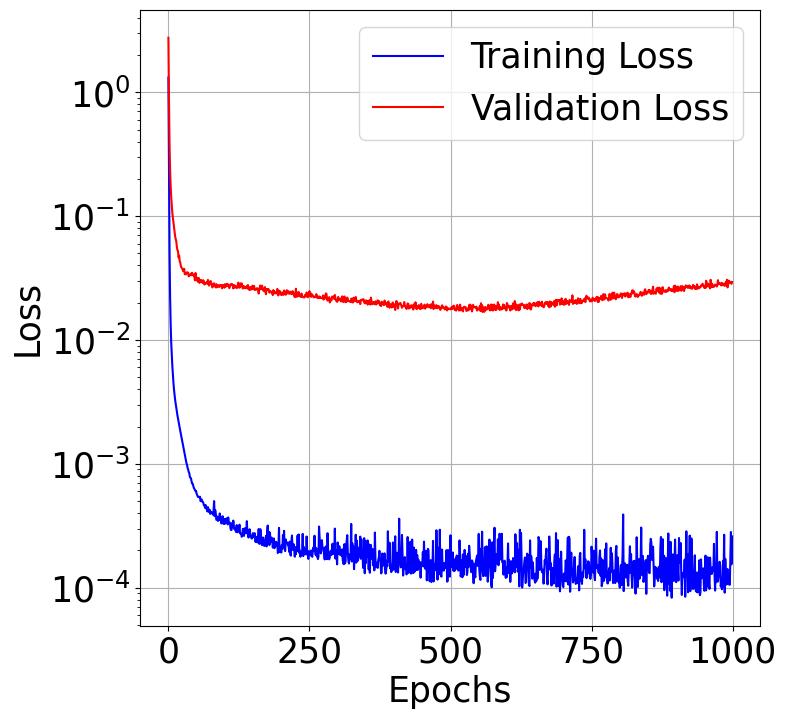

In [47]:
fig, ax = plt.subplots(1, figsize=(8,8))
ax.plot(train_loss_log, label="Training Loss", c="b")
ax.plot(test_loss_log, label="Validation Loss", c="r")
ax.tick_params(axis="both", labelsize=25)
ax.set_yscale("log")
ax.set_ylabel("Loss", fontsize=25)
ax.set_xlabel("Epochs", fontsize=25)
ax.legend(fontsize=25)
ax.grid()
plt.show()
ax.legend()

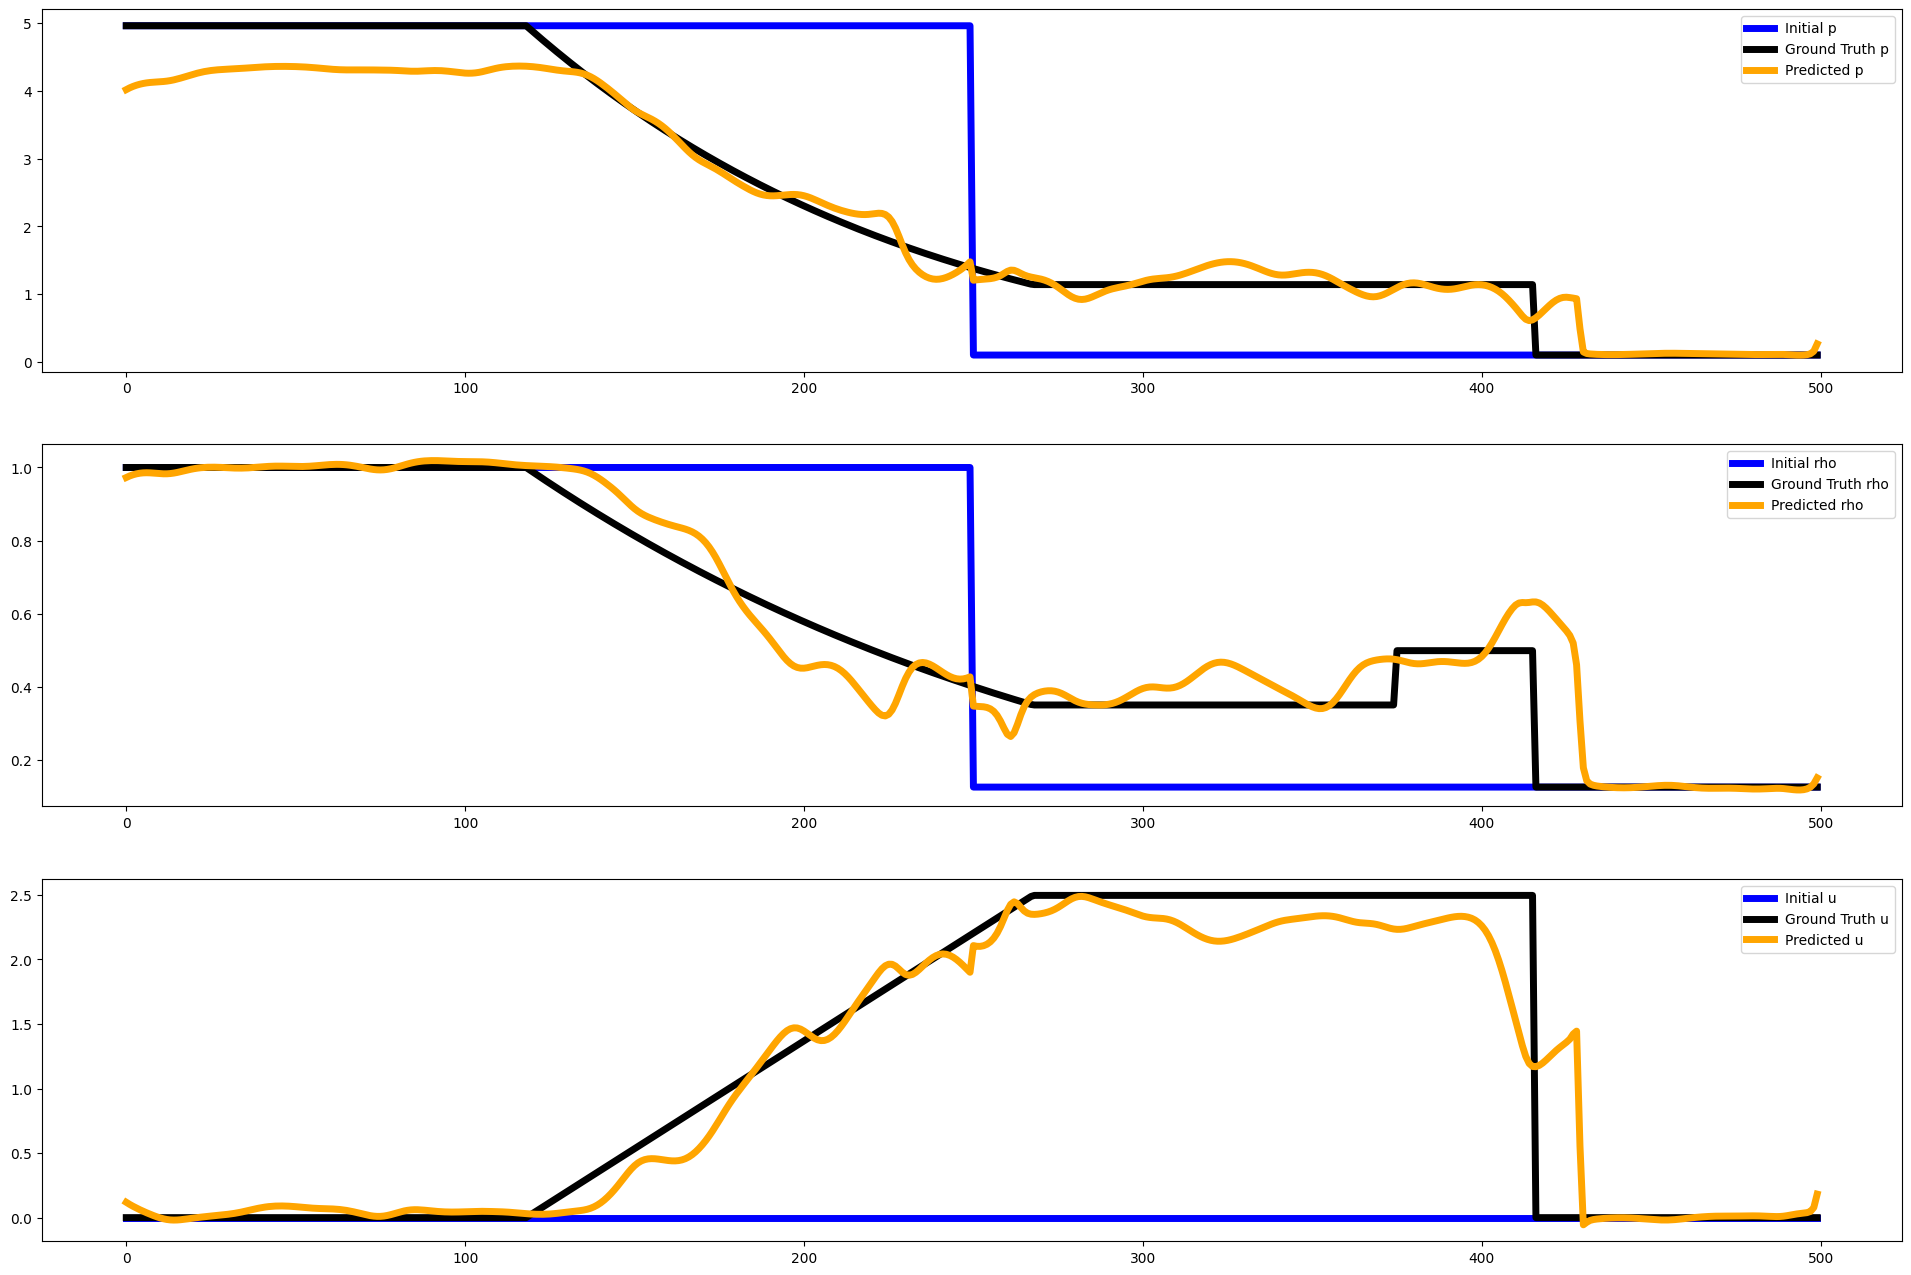

In [56]:
dpi = 100
num_figs = 1
rows = 1
cols = 3
for k in range(num_figs):
  fig, ax = plt.subplots(cols, rows, figsize=(24, 16), dpi=dpi)
  rand_ex = np.random.randint(0, len(test_dataset))
  input, output = test_dataset[rand_ex]
  input = torch.unsqueeze(input, 0)
  output = torch.unsqueeze(output, 0)
  #print(input.size())
  #print(output.size())
  pred = model(input)
  # print(pred.size())
  input = torch.squeeze(input, 0)
  output = torch.squeeze(output, 0)
  pred = torch.squeeze(pred, 0)
  #print(input.size())
  #print(output.size())
  #print(pred.size())
  input_x=input[:,0].detach().cpu().numpy()
  #print(input_x)
  input_p=input[:,1].detach().cpu().numpy()
  input_rho=input[:,2].detach().cpu().numpy()
  input_u=input[:,3].detach().cpu().numpy()

  output_p=output[:,0].detach().cpu().numpy()
  output_rho=output[:,1].detach().cpu().numpy()
  output_u=output[:,2].detach().cpu().numpy()

  pred_p=pred[:,0].detach().cpu().numpy()
  pred_rho=pred[:,1].detach().cpu().numpy()
  pred_u=pred[:,2].detach().cpu().numpy()

  ax[0].plot(input_p, label="Initial p", c="b", lw=5)
  ax[0].plot(output_p, label="Ground Truth p", c="k", lw=5)
  ax[0].plot(pred_p, label="Predicted p", c="orange", lw=5)
  ax[0].legend()

  ax[1].plot(input_rho, label="Initial rho", c="b", lw=5)
  ax[1].plot(output_rho, label="Ground Truth rho", c="k", lw=5)
  ax[1].plot(pred_rho, label="Predicted rho", c="orange", lw=5)
  ax[1].legend()

  ax[2].plot(input_u, label="Initial u", c="b", lw=5)
  ax[2].plot(output_u, label="Ground Truth u", c="k", lw=5)
  ax[2].plot(pred_u, label="Predicted u", c="orange", lw=5)
  ax[2].legend()



In [ ]:
def activation(name='tanh'):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['SiLU']:
        return nn.SiLU()
    else:
        raise ValueError('Unknown activation function')